In [191]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [263]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

I0000 00:00:1739423139.551095 44079274 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3


W0000 00:00:1739423139.589021 44361531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739423139.596459 44361531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [264]:
video_path = '../test_chop.mp4'
output_video_path = "output_video.mp4"
temp_frame_dir = "temp_frames"
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
scale_factor = 0.3
target_fps = 10

In [265]:
def extract_all_frames(video_path, output_dir, target_fps = 10, scale_factor=0.3):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get the original FPS of the video
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if original_fps <= 0:
        raise ValueError("Unable to determine the original FPS of the video.")

    # Calculate the frame interval based on the target FPS
    frame_interval = int(round(original_fps / target_fps))
    if frame_interval < 1:
        frame_interval = 1  # Ensure at least 1 frame is skipped

    frame_count = 0
    saved_frame_count = 0

    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frames at the specified interval
        if frame_count % frame_interval == 0:
            # Resize the frame if scale_factor is provided
            if scale_factor != 1.0:
                frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

            # Save the frame
            frame_filename = os.path.join(output_dir, f"{saved_frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_frame_count} frames to {output_dir} at {target_fps} FPS.")


video_name = os.path.splitext(os.path.basename(video_path))[0]
video_dir = f"{video_name}_dir"
extract_all_frames(video_path, video_dir, target_fps, scale_factor)

Extracted 209 frames to test_chop_dir at 10 FPS.


In [266]:
frame_files = sorted(glob.glob(os.path.join(video_dir, '*.jpg')))  # Assuming frames are in jpg format
if not frame_files:
    raise ValueError("No frames found in the specified directory.")

In [267]:
frame_count = 0
best_frame_number = -1
best_fingertip_positions = []
best_confidence = 0
max_hands_detected = 0
# Read frames from the directory
for frame_file in frame_files:
    frame = cv2.imread(frame_file)
    if frame is None:
        continue

    # Convert frame to RGB for Mediapipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_rgb = cv2.resize(frame_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # Process the frame with MediaPipe Hands
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        hands_detected = len(results.multi_hand_landmarks)
        best_frame_confidence = 0
        selected_fingertips = []

        # Get fingertip locations for all detected hands in the frame
        all_fingertip_positions = []

        for hand_landmarks in results.multi_hand_landmarks:

            fingertip_indices = [4, 8, 12, 16, 20]
        
            # Extract visibility scores for fingertip landmarks
            visibility_scores = [
                hand_landmarks.landmark[i].visibility for i in fingertip_indices
            ]
            
            # Calculate the average fingertip visibility
            visibility_scores = [landmark.visibility for landmark in hand_landmarks.landmark]
            average_visibility = sum(visibility_scores) / len(visibility_scores)

            # Get handedness confidence (left or right hand)
            handedness = results.multi_handedness[0]
            handedness_confidence = handedness.classification[0].score

            # Calculate custom confidence as the average of visibility and handedness confidence
            # print(average_visibility)
            confidence = (average_visibility + handedness_confidence) / 2

            # Store the fingertip positions for this hand
            fingertip_positions = []
            for idx in fingertip_indices:  # Fingertips: 4=thumb, 8=index, 12=middle, 16=ring, 20=pinky
                x = hand_landmarks.landmark[idx].x * frame.shape[1]
                y = hand_landmarks.landmark[idx].y * frame.shape[0]
                fingertip_positions.append((x, y))

            # Track the best frame based on detection confidence and number of hands detected
            if confidence > best_frame_confidence:
                best_frame_confidence = confidence

            # Add the fingertip positions to the array for the current hand
            all_fingertip_positions.append(fingertip_positions)

        # Prioritize frames with more hands detected and higher confidence
        if hands_detected >= max_hands_detected:
            if hands_detected > max_hands_detected or best_frame_confidence > best_confidence:
                max_hands_detected = hands_detected
                best_confidence = best_frame_confidence
                best_frame_number = frame_count
                best_fingertip_positions = all_fingertip_positions

    frame_count += 1

# Output the details of the best frame
if best_frame_number != -1:
    print(f"Best Frame: {best_frame_number}")
    print(f"Number of Hands Detected: {max_hands_detected}")
    print(f"Fingertip Positions for All Hands:")
    for i, fingertips in enumerate(best_fingertip_positions):
        print(f"Hand {i+1} Fingertips: {fingertips}")
else:
    print("No hands detected in any frame.")

Best Frame: 127
Number of Hands Detected: 2
Fingertip Positions for All Hands:
Hand 1 Fingertips: [(262.45222091674805, 155.45541751384735), (306.3486785888672, 162.97420835494995), (291.3255615234375, 175.98239850997925), (268.6801986694336, 187.88886380195618), (249.35126495361328, 200.9096646308899)]
Hand 2 Fingertips: [(277.55471420288086, 109.06969928741455), (303.58898162841797, 107.16744768619537), (282.9851016998291, 108.92103624343872), (260.8795623779297, 107.39629375934601), (236.4975872039795, 108.43436658382416)]


Successfully loaded best frame: test_chop_dir/0127.jpg
Hand 1 Finger Tips Coordinates:
[(262.45222091674805, 155.45541751384735), (306.3486785888672, 162.97420835494995), (291.3255615234375, 175.98239850997925), (268.6801986694336, 187.88886380195618), (249.35126495361328, 200.9096646308899)]
Hand 2 Finger Tips Coordinates:
[(277.55471420288086, 109.06969928741455), (303.58898162841797, 107.16744768619537), (282.9851016998291, 108.92103624343872), (260.8795623779297, 107.39629375934601), (236.4975872039795, 108.43436658382416)]


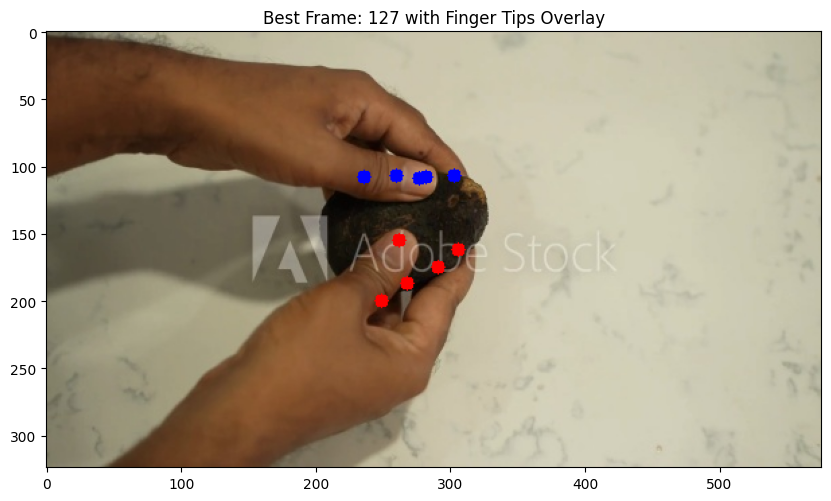

In [268]:
# Load the best frame from the directory
best_frame_filename = f'{video_dir}/{best_frame_number:04d}.jpg'  # Assuming frame numbers are zero-padded
best_frame = cv2.imread(best_frame_filename)

if best_frame is None:
    print(f"Error: Could not load the best frame {best_frame_filename}")
else:
    print(f"Successfully loaded best frame: {best_frame_filename}")

# Copy the best frame to overlay the fingertip points
overlay_image = best_frame.copy()

# Display the fingertip points for each hand
for hand_index, fingertips in enumerate(best_fingertip_positions):
    for (x, y) in fingertips:
        x, y = int(x), int(y)  # Explicitly convert to integers
        # Choose color based on hand (Red for Hand 1, Blue for Hand 2, etc.)
        color = (0, 0, 255) if hand_index == 0 else (255, 0, 0)  # Red for Hand 1, Blue for Hand 2
        cv2.circle(overlay_image, (x, y), radius=5, color=color, thickness=-1)

    # Print the coordinates of the fingertip points
    print(f"Hand {hand_index + 1} Finger Tips Coordinates:")
    print(fingertips)

# Visualize the results using matplotlib
plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title(f"Best Frame: {best_frame_number} with Finger Tips Overlay")
plt.show()

In [269]:
# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [270]:
device = torch.device("cpu")

# # select the device for computation
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
# print(f"using device: {device}")

# if device.type == "cuda":
#     # use bfloat16 for the entire notebook
#     torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
#     # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
#     if torch.cuda.get_device_properties(0).major >= 8:
#         torch.backends.cuda.matmul.allow_tf32 = True
#         torch.backends.cudnn.allow_tf32 = True
# elif device.type == "mps":
#     print(
#         "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
#         "give numerically different outputs and sometimes degraded performance on MPS. "
#         "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
#     )

In [271]:
from sam2.build_sam import build_sam2_video_predictor

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [272]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

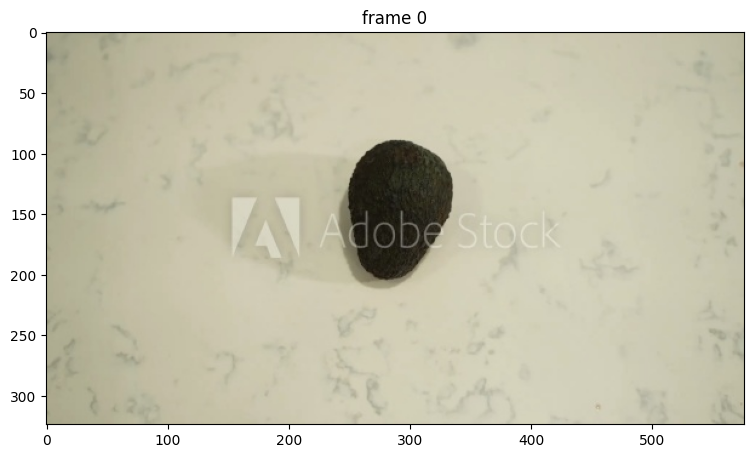

In [273]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [274]:
# torch.mps.empty_cache()
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 209/209 [00:02<00:00, 78.91it/s]


In [275]:
predictor.reset_state(inference_state)

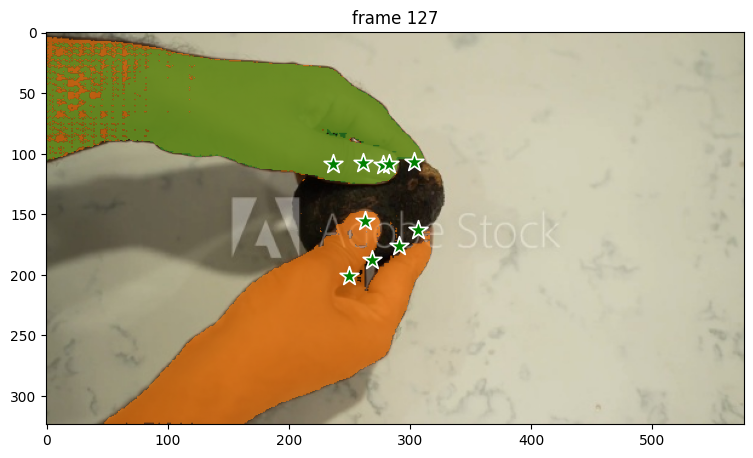

In [276]:
ann_frame_idx = best_frame_number  # the frame index we interact with
ann_obj_id_hand1 = 1  # give a unique id to each object we interact with (it can be any integers)
ann_obj_id_hand2 = 2  # give a unique id to each object we interact with (it can be any integers)
prompts = {}

# Check if there are fingertip positions for Hand 1
if len(best_fingertip_positions) > 0:
    hand1_finger_tips = best_fingertip_positions[0]  # Assuming Hand 1 is the first hand in the list
    
    if len(hand1_finger_tips) > 0:
        points = np.array(hand1_finger_tips, dtype=np.float32)
        # For labels, `1` means positive click and `0` means negative click
        labels = np.ones(len(hand1_finger_tips), dtype=np.int32)
        
        # Store the points and labels in the prompts dictionary
        prompts[ann_obj_id_hand1] = points, labels
        
        # Call predictor.add_new_points_or_box() with the updated points and labels for Hand 1
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id_hand1,
            points=points,
            labels=labels,
        )

# Check if there are fingertip positions for Hand 2
if len(best_fingertip_positions) > 1:
    hand2_finger_tips = best_fingertip_positions[1]  # Assuming Hand 2 is the second hand in the list
    
    if len(hand2_finger_tips) > 0:
        points = np.array(hand2_finger_tips, dtype=np.float32)
        # For labels, `1` means positive click and `0` means negative click
        labels = np.ones(len(hand2_finger_tips), dtype=np.int32)
        
        # Store the points and labels in the prompts dictionary
        prompts[ann_obj_id_hand2] = points, labels
        
        # Call predictor.add_new_points_or_box() with the updated points and labels for Hand 2
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id_hand2,
            points=points,
            labels=labels,
        )


# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 128/128 [16:53<00:00,  7.92s/it] 


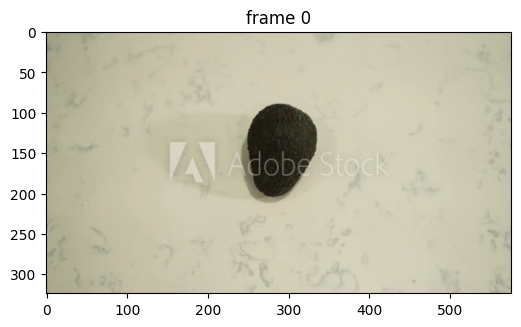

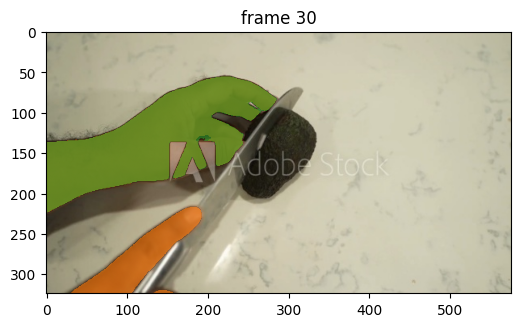

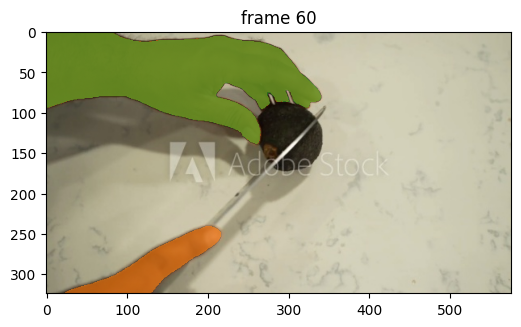

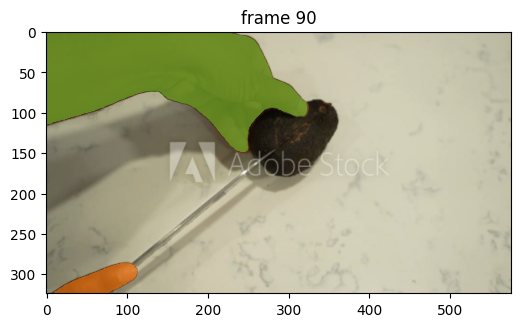

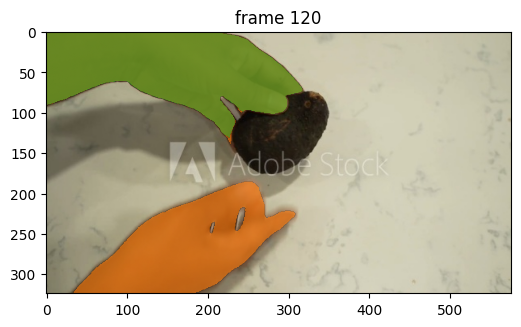

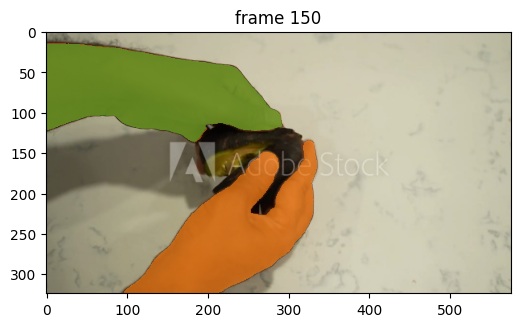

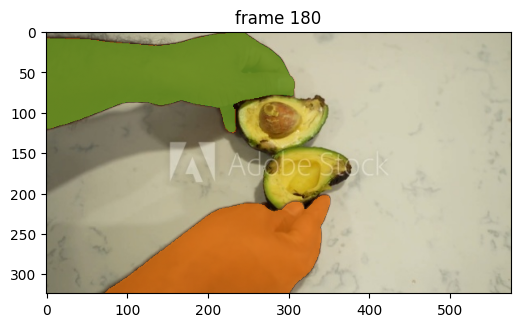

In [277]:
# video_segments = {}  # video_segments contains the per-frame segmentation results
# for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }

video_segments_forward = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=ann_frame_idx):
    video_segments_forward[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# Propagate backward in time (from ann_frame_idx to the start of the video)
video_segments_backward = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=ann_frame_idx, reverse=True):
    video_segments_backward[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# Combine forward and backward results
video_segments = {**video_segments_backward, **video_segments_forward}

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [278]:
import imageio

# Assuming video_segments, frame_names, and video_dir are already defined


os.makedirs(temp_frame_dir, exist_ok=True)

# List to store the paths of the generated frames
frame_paths = []

for out_frame_idx in range(0, len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    
    # Save the frame with the mask applied
    frame_path = os.path.join(temp_frame_dir, f"frame_{out_frame_idx:04d}.png")
    plt.savefig(frame_path)
    plt.close()
    
    # Append the frame path to the list
    frame_paths.append(frame_path)

# Compile the frames into a video
with imageio.get_writer(output_video_path, fps=target_fps) as writer:
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)


print(f"Video saved to {output_video_path}")

/var/folders/p4/8ylcj22s0jscrsjzklw073mm0000gn/T/ipykernel_4089/940714027.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


Video saved to output_video.mp4


In [279]:
import shutil

if os.path.exists(temp_frame_dir):
    # Delete the directory and all its contents
    shutil.rmtree(temp_frame_dir)
    print(f"Directory '{temp_frame_dir}' and all its contents have been deleted.")
else:
    print(f"Directory '{temp_frame_dir}' does not exist.")

if os.path.exists(video_dir):
    # Delete the directory and all its contents
    shutil.rmtree(video_dir)
    print(f"Directory '{video_dir}' and all its contents have been deleted.")
else:
    print(f"Directory '{video_dir}' does not exist.")

Directory 'temp_frames' and all its contents have been deleted.
Directory 'test_chop_dir' and all its contents have been deleted.


In [22]:
exit()

: 